# Analysis, Cleaning and Visualization of Used Car Dataset obtained by Scraping Kijiji

In [201]:
import warnings
warnings.filterwarnings('ignore')

In [202]:
#Importing required modules
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,inspect, func
from config import password

import seaborn as sns
import scipy.stats as ss
from collections import Counter
import math 
from scipy import stats
import datetime
import matplotlib
import pickle
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from spark_sklearn import GridSearchCV
from spark_sklearn.util import createLocalSparkSession
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

from statsmodels.graphics.tsaplots import plot_acf
import sqlite3

In [203]:
#Connecting to the sql database
connection_string = "postgres:"+password+"@localhost:5432/hondadb"
engine = create_engine(f'postgresql://{connection_string}')

In [245]:
# Reading the data from sql database
sql_DF = pd.read_sql("SELECT * FROM cardb",
                     con=engine)

In [246]:
#Selecting the useful columns only and removing unuseful columns
csql_DF=sql_DF[['Car Type', 'Model', 'Price', 'Milage', 'Year']]

In [247]:
csql_DF.head()

,Car Type,Model,Price,Milage,Year
0,Ford,F-150,33888,64965,2018
1,Mercedes-Benz,GLS,54887,57449,2017
2,Dodge,Journey,18888,28567,2016
3,Ford,Edge,30995,63500,2017
4,Nissan,Versa,18988,87760,2019


In [248]:
#Checking for duplicates
csql_DF.duplicated(subset=None, keep='first')

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
40963    False
40964    False
40965    False
40966    False
40967    False
40968    False
40969    False
40970    False
40971    False
40972    False
40973    False
40974    False
40975    False
40976    False
40977    False
40978    False
40979    False
40980    False
40981    False
40982    False
40983    False
40984    False
40985    False
40986    False
40987    False
40988    False
40989    False
40990    False
40991    False
40992    False
Length: 40993, dtype: bool

In [249]:
#Droping duplicate
df=csql_DF.drop_duplicates(subset=None, keep='first')

In [250]:
#Checking the dataset
df.describe()

,Car Type,Model,Price,Milage,Year
count,40991,40991,40991,40991,40991
unique,70,1014,14952,27261,77
top,Ford,F-150,14995,90,2020
freq,4919,1729,199,97,9748


In [251]:
#converting the Milage, Year and Price values to numeric
df['Milage'] = pd.to_numeric(df['Milage'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)

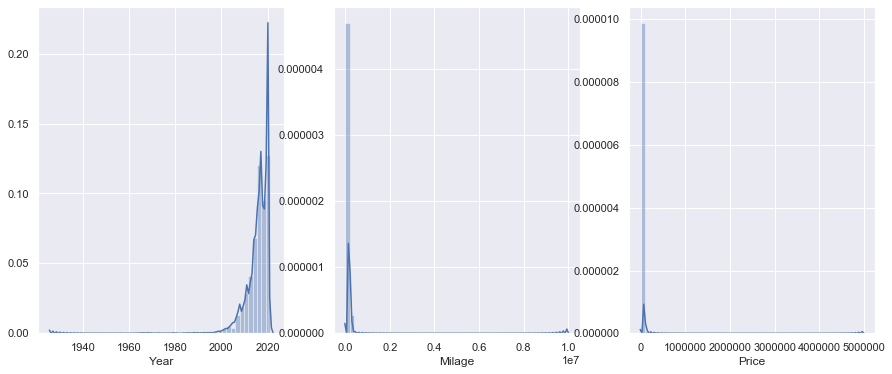

In [252]:
#Plotting out distributions for the numeric variables to see whether they are normally distributed
warnings.filterwarnings("ignore")
sns.set()
fig, ((ax1,ax2,ax3))=plt.subplots(ncols=3,nrows=1,figsize=(15,6)) 
sns.distplot(df['Year'],ax=ax1);
sns.distplot(df['Milage'],ax=ax2);            
sns.distplot(df['Price'],ax=ax3);

In [253]:
#removing some obvious outliers in model year, milage and price
df = df[(df.Year >= 1989)
      & (df.Milage <= 500000)
      & (df.Price <= 200000)]

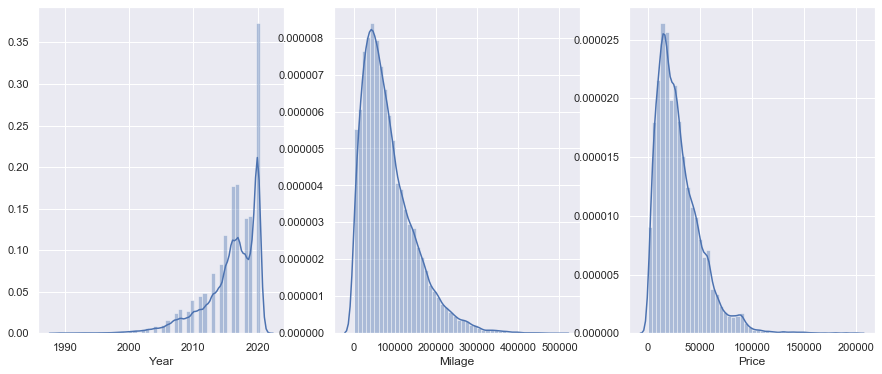

In [254]:
#Plotting out distributions for the numeric variables to see whether they are normally distributed again after removing obvious outliers
warnings.filterwarnings("ignore")
sns.set()
fig, ((ax1,ax2,ax3))=plt.subplots(ncols=3,nrows=1,figsize=(15,6)) 
sns.distplot(df['Year'],ax=ax1);
sns.distplot(df['Milage'],ax=ax2);            
sns.distplot(df['Price'],ax=ax3);

Text(0, 0.5, 'Count of cars')

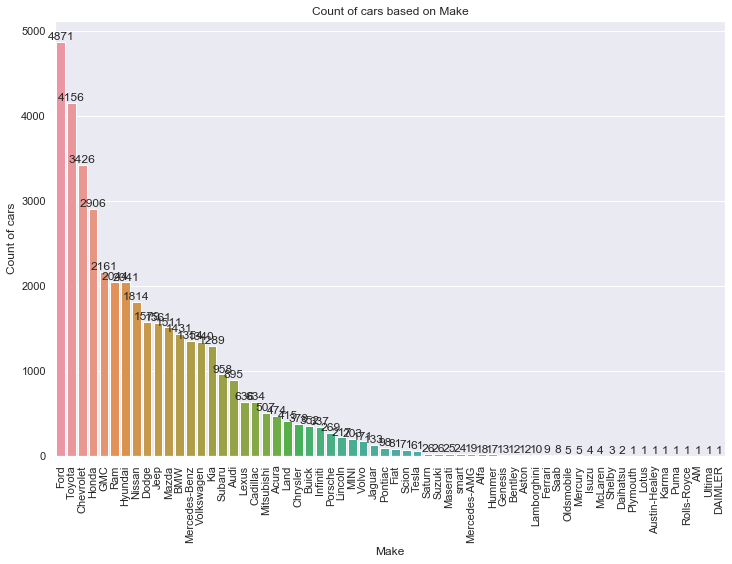

In [255]:
#Plotting the number of each cars make
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Car Type', data = df, order = df['Car Type'].value_counts().index)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on Make")
plt.xlabel("Make")
plt.ylabel("Count of cars")

Text(0, 0.5, 'Count of cars')

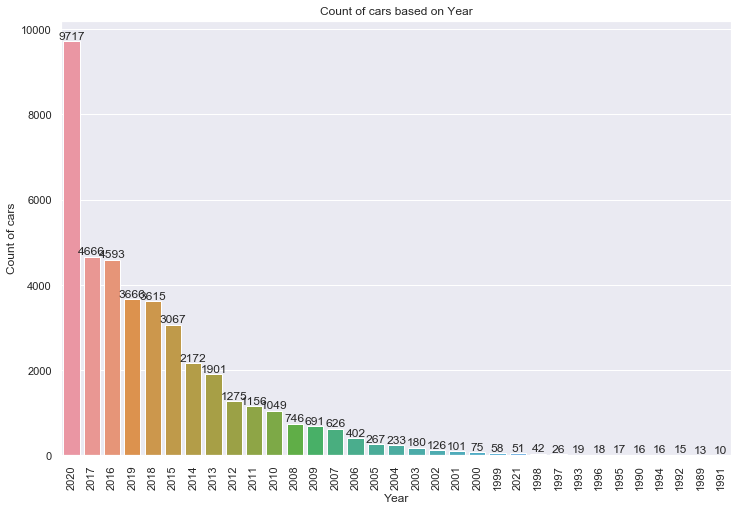

In [221]:
#Plotting the number of model years
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Year', data = df, order = df['Year'].value_counts().index)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on Year")
plt.xlabel("Year")
plt.ylabel("Count of cars")

Text(0, 0.5, 'Price')

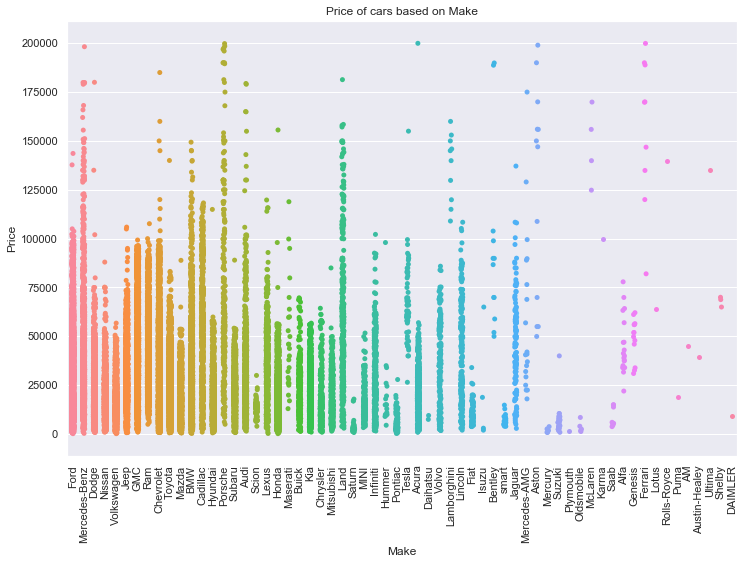

In [222]:
#checking the prices of each make
plt.figure(figsize = (12, 8))

ax=sns.stripplot(x='Car Type',y='Price', data=df)

plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Price of cars based on Make")
plt.xlabel("Make")
plt.ylabel("Price")

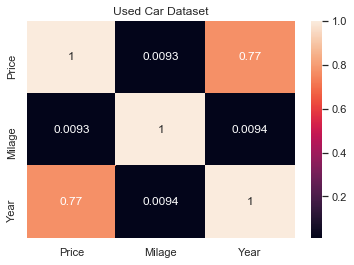

In [225]:
#checking the correlations between numerical values in the dataset
numeric_corr = df[['Price','Milage','Year']].corr(method='spearman'); # non-parametric
sns.heatmap(numeric_corr,annot=True);
plt.title('Used Car Dataset');

#### Analysis of the Price feature

In [227]:
# Converting all objects and strings to numberic values
df['Milage'] = pd.to_numeric(df['Milage'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)

In [228]:
df['Price'].describe()

count     40625.000000
mean      29955.204086
std       21591.735858
min         200.000000
25%       14499.000000
50%       24995.000000
75%       40495.000000
max      199950.000000
Name: Price, dtype: float64

In [229]:
df['Milage'].describe()

count     40625.000000
mean      84053.145157
std       63849.692864
min           3.000000
25%       37354.000000
50%       69000.000000
75%      116062.000000
max      500000.000000
Name: Milage, dtype: float64

In [230]:
df['Year'].describe()

count    40625.000000
mean      2015.842437
std          4.344107
min       1989.000000
25%       2014.000000
50%       2017.000000
75%       2019.000000
max       2021.000000
Name: Year, dtype: float64

Skewness: 1.663365
Kurtosis: 5.057019


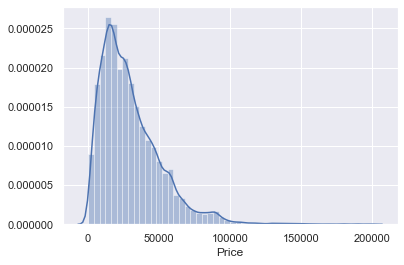

In [231]:
sns.distplot(df['Price'])
#skewness and kurtosis
print("Skewness: %f" % df['Price'].skew())
print("Kurtosis: %f" % df['Price'].kurt())

The data are skewed (skewness = 1.66) and have a kurtosis of 5.05 which means there are still outliers in data.

#### Investigation of Corelations (Numerical Features)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


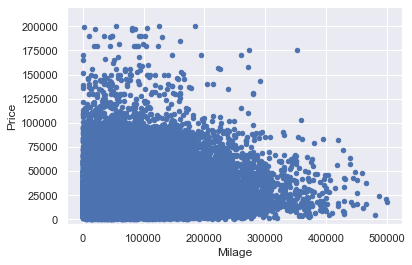

In [240]:
# distribution of  Milage / Price
data = pd.concat([df['Price'], df['Milage']], axis=1)
data.plot.scatter(x='Milage', y='Price', ylim=(-5000,220000));

It cen be observed that lesser is the milage, the higher tends to be the price. Price and Milage are in a reverse correlation. Some milage bins show some outliers.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


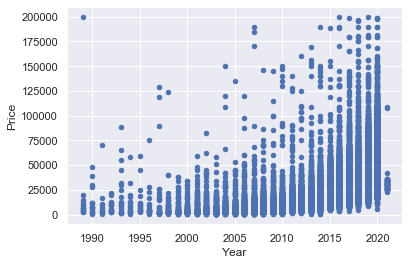

In [241]:
# distribution of  Year / Price
data = pd.concat([df['Price'], df['Year']], axis=1)
data.plot.scatter(x='Year', y='Price');#, ylim=(-5000,220000));

From the plot above, It cen be observed that the newer the car, the higher the price will be. Price and model year are in a direct correlation. One outlier is observed where the car is very old however the price is high which might be because of the cars being a classic car. We will remove that car.

<Figure size 2160x2160 with 0 Axes>

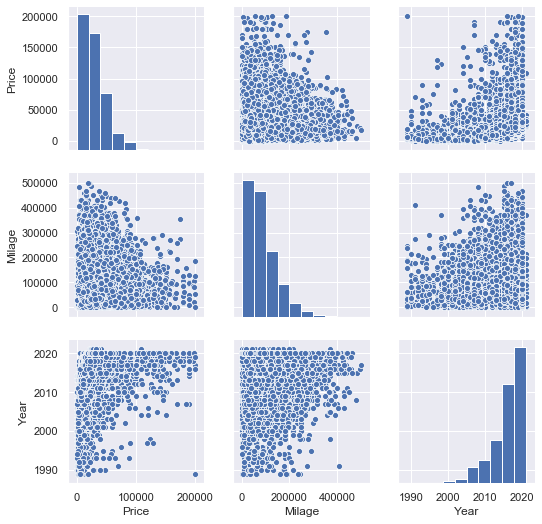

In [242]:
# PairPlots to have more insight into the correlations between numerical features
plt.figure(figsize = (30,30))
sns.pairplot(df)
plt.show()

#### Investigation of Corelations (categorical Features)

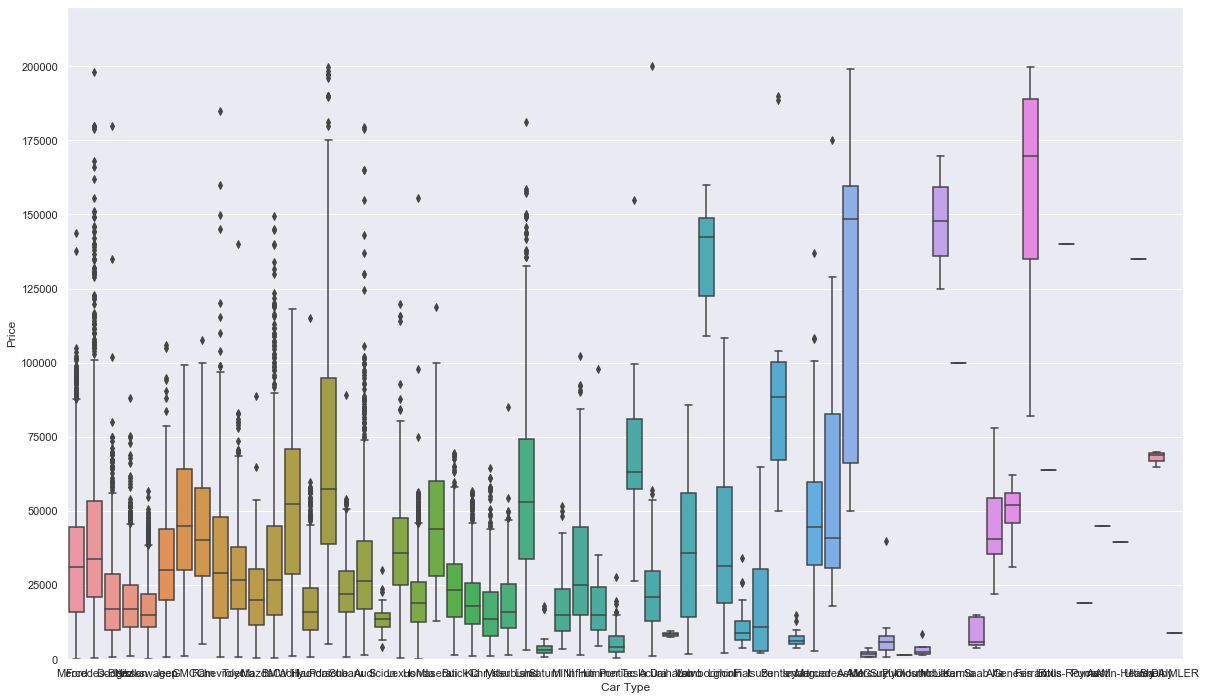

In [239]:
# Box plot Make Model/Price
data = pd.concat([df['Price'], df['Car Type']], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x="Car Type", y="Price", data=data)
fig.axis(ymin=0, ymax=220000);

We can clearly see that the most expensive models are Pilot and Odussey. There are some outliers in different models.

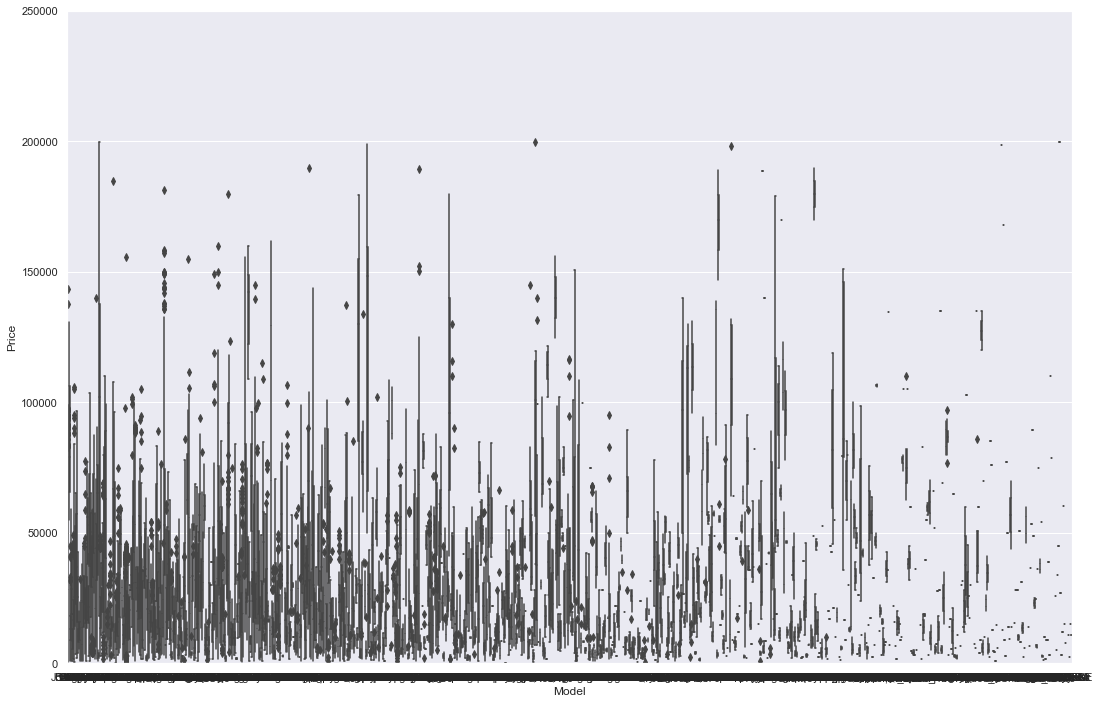

In [155]:
# Box plot Model/Price
data = pd.concat([df['Price'], df['Model']], axis=1)
f, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x='Model', y="Price", data=data)
fig.axis(ymin=0, ymax=250000);

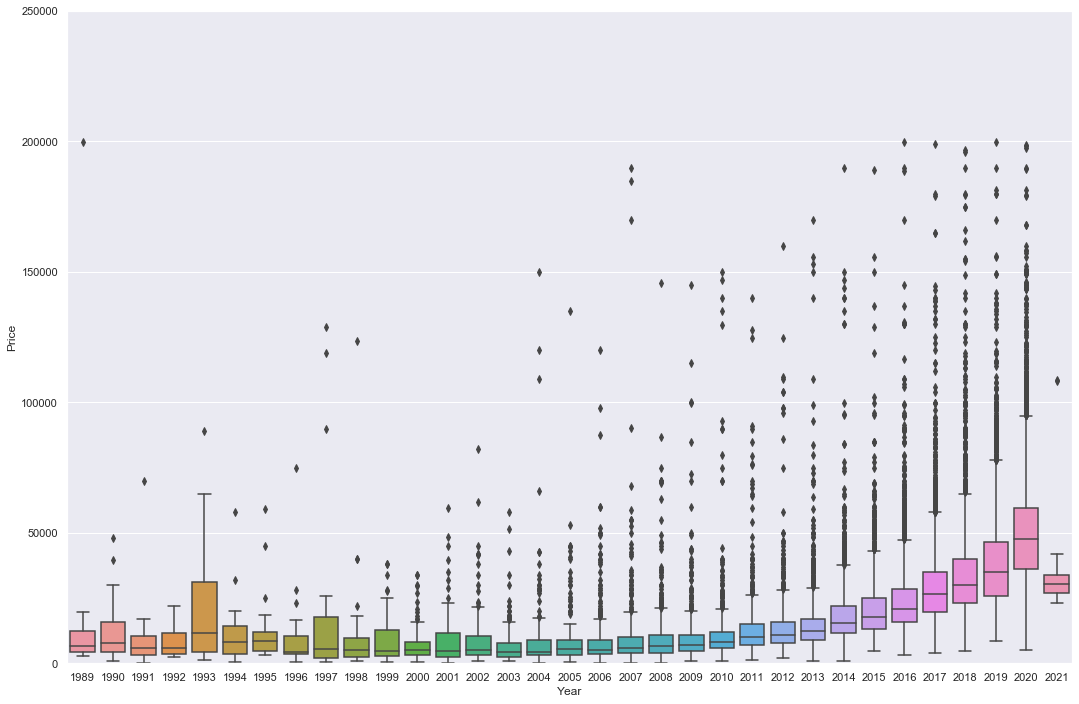

In [156]:
# Box plot Year/Price
data = pd.concat([df['Price'], df['Year']], axis=1)
f, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x='Year', y="Price", data=data)
fig.axis(ymin=0, ymax=250000);

Obviously there is a correlation bertween the year (model year) and the price. The newer the car, the higher the price.

The data show that cars with automatic transmission are more expensive than the maual ones and also among automatic cars there are some outliers.

#### Investigation of the Importance of Features Related to Target

In [157]:
# Finding most important features relative to Price
corr = df.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

Price     1.000000
Year      0.568398
Milage    0.007739
Name: Price, dtype: float64


Between the year (model year) and price there is a direct correlation and the newer the car the higher will be the price. And between milage and price there is a reverse correlation and the higher the milage the lower the price will be. 

#### Correlation Matrix  to understand the correlations all features including numerical and categorical

In [163]:
df['Model'] = df['Model'].astype(str)
df['Car Type'] = df['Car Type'].astype(str)

In [164]:
numcols = ['Price', 'Milage', 'Year']
catcols = ['Model', 'Car Type']

In [165]:
df = df[numcols + catcols]

In [166]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError('cannot handle data conversion of type: {} to {}'.format(type(data),to))
    else:
        return converted
    
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                          return_results = False, **kwargs):
    """
    Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and
    continuous features using:
     - Pearson's R for continuous-continuous cases
     - Correlation Ratio for categorical-continuous cases
     - Cramer's V or Theil's U for categorical-categorical cases
    :param dataset: NumPy ndarray / Pandas DataFrame
        The data-set for which the features' correlation is computed
    :param nominal_columns: string / list / NumPy ndarray
        Names of columns of the data-set which hold categorical values. Can also be the string 'all' to state that all
        columns are categorical, or None (default) to state none are categorical
    :param mark_columns: Boolean (default: False)
        if True, output's columns' names will have a suffix of '(nom)' or '(con)' based on there type (eda_tools or
        continuous), as provided by nominal_columns
    :param theil_u: Boolean (default: False)
        In the case of categorical-categorical feaures, use Theil's U instead of Cramer's V
    :param plot: Boolean (default: True)
        If True, plot a heat-map of the correlation matrix
    :param return_results: Boolean (default: False)
        If True, the function will return a Pandas DataFrame of the computed associations
    :param kwargs:
        Arguments to be passed to used function and methods
    :return: Pandas DataFrame
        A DataFrame of the correlation/strength-of-association between all features
    """

    dataset = convert(dataset, 'dataframe')
    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]],dataset[columns[i]])
                        else:
                            cell = cramers_v(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        plt.figure(figsize=(20,20))#kwargs.get('figsize',None))
        sns.heatmap(corr, annot=kwargs.get('annot',True), fmt=kwargs.get('fmt','.2f'), cmap='coolwarm')
        plt.show()
    if return_results:
        return corr

In [167]:
df = df.fillna(0)
results = associations(df, nominal_columns=catcols,return_results=True)

KeyError: "None of [Int64Index([9271], dtype='int64')] are in the [index]"

As it can be observed we have direct correlation (positive correlation) between price and year i.e. the newer the car, the higher the price. Also we have negative correlation between price and milage as well as milage and year. This means the more milage, the lower the price, and the newer the car, the less milage on it.

#### Preprocessing

In [168]:
# Checking for missing values -> no missing values
df.isnull().sum()

Price       0
Milage      0
Year        0
Model       0
Car Type    0
dtype: int64

In [169]:
# Checking for values of numerical features
# we need to fix these problems
df.describe()

,Price,Milage,Year
count,40625.000000,40625.000000,40625.000000
mean,29955.204086,84053.145157,2015.842437
std,21591.735858,63849.692864,4.344107
min,200.000000,3.000000,1989.000000
25%,14499.000000,37354.000000,2014.000000
50%,24995.000000,69000.000000,2017.000000
75%,40495.000000,116062.000000,2019.000000
max,199950.000000,500000.000000,2021.000000


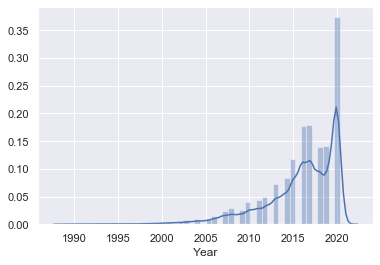

In [170]:
# Record distribution over the year
sns.distplot((df["Year"]))

In [171]:
# Checking values of categorical features
cat_val = ["Model"]
for col in cat_val:
    print ([col]," : ", csql_DF[col].unique())

['Model']  :  ['F-150' 'GLS' 'Journey' ... 'CBR600' 'Chrysler' 'G25X']


#### Outlier management


##### Bivariate Analysis

##### Removing Outliers by Model



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


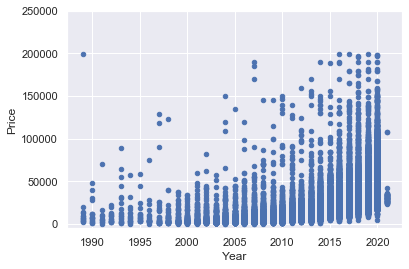

In [172]:
# Bivariate analysis Price / Year
data = pd.concat([df['Price'], df['Year']], axis=1)
data.plot.scatter(x='Year', y='Price', ylim=(-5000,250000));

In [173]:
from numpy import percentile
from functools import partial

category='Model'

models = df[category].unique()

"""
Here we are taking the values between the 25th and 80th percentile of the 
gaussian curve.
"""
p25 = df.groupby(by=category)[category,'Price'].agg(lambda x: percentile(x['Price'], 20))
p80 = df.groupby(by=category)[category,'Price'].agg(lambda x: percentile(x['Price'], 80))

In [174]:
# Now this strategy is applied to the 3k models
# depending on the hardware
models = df[category].unique()

cdf = pd.DataFrame()

for i,m in enumerate(models):
    cdf=cdf.append(df[( (df[category] == m ) & ( (df["Price"] > p25.Model[m]) & (df["Price"] <= p80.Model[m])) ) ],ignore_index=True)

In [175]:
cdf

,Price,Milage,Year,Model,Car Type
0,33888,64965,2018,F-150,Ford
1,46980,100000,2018,F-150,Ford
2,29995,88300,2016,F-150,Ford
3,43701,74900,2020,F-150,Ford
4,49950,73987,2019,F-150,Ford
5,34999,58443,2018,F-150,Ford
6,36999,74526,2016,F-150,Ford
7,26379,35400,2016,F-150,Ford
8,35994,79950,2019,F-150,Ford
9,31995,133000,2016,F-150,Ford


#### Create database connection

In [176]:
from config import password
connection_string = "postgres:"+password+"@localhost:5432/hondadb"
engine = create_engine(f'postgresql://{connection_string}')

In [177]:
cdf.to_sql(name='cleanedcardb', con=engine, if_exists='replace', index=True)

In [178]:
csql_DF_cleaned = pd.read_sql("SELECT * FROM cleanedcardb",
                     con=engine)

In [179]:
csql_DF_cleaned.describe()

,index,Price,Milage,Year
count,23708.000000,23708.000000,23708.000000,23708.000000
mean,11853.500000,29524.540408,83909.759153,2016.570736
std,6844.054427,17250.420156,63811.039957,3.145535
min,0.000000,1495.000000,3.000000,1989.000000
25%,5926.750000,16779.750000,37307.750000,2015.000000
50%,11853.500000,25985.500000,69000.000000,2017.000000
75%,17780.250000,38985.250000,116000.000000,2019.000000
max,23707.000000,169800.000000,500000.000000,2021.000000


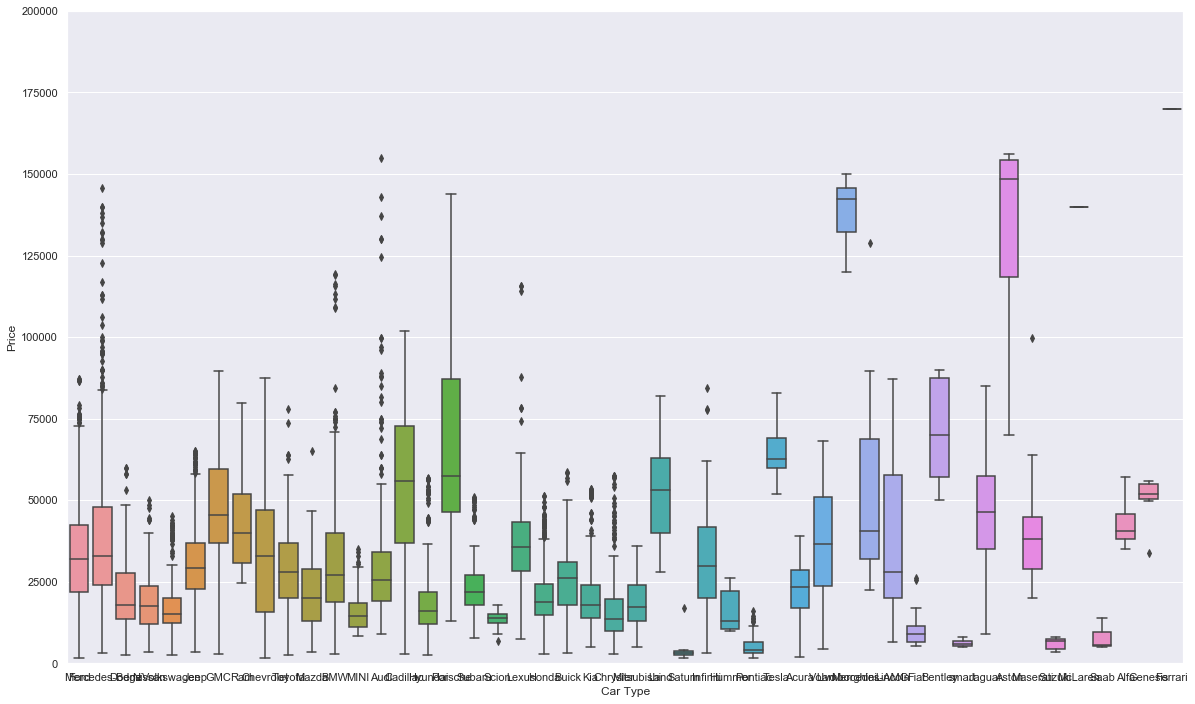

In [180]:
# Box Plot showing car manufacturer / Price range after cleaning

data = pd.concat([csql_DF_cleaned['Price'], csql_DF_cleaned['Car Type']], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x='Car Type', y="Price", data=data)
fig.axis(ymin=0, ymax=200000);

In [186]:
print("Too old: %d" % csql_DF_cleaned.loc[csql_DF_cleaned.Year <= 1995].count()['index'])
print("Too new: %d" % csql_DF_cleaned.loc[csql_DF_cleaned.Year >= 2021].count()['index'])
print("Too few km: " , csql_DF_cleaned.loc[csql_DF_cleaned.Milage <= 10].count()['index'])
print("Too many km: " , csql_DF_cleaned.loc[csql_DF_cleaned.Milage >= 400000].count()['index'])


Too old: 21
Too new: 28
Too few km:  23
Too many km:  26


In [187]:
# Replace the NaN values for categoric attributes
csql_DF_cleaned['Model'].fillna(value='blank', inplace=True)

# Drop duplicates
csql_DF_cleaned = csql_DF_cleaned.drop_duplicates(["Year", "Milage", "Price", "Model", "Car Type"])
csql_DF_cleaned.drop_duplicates(keep=False, inplace=True)
# Remove outliers
csql_DF_cleaned = csql_DF_cleaned[
        (csql_DF_cleaned.Year >= 1995) 
      & (csql_DF_cleaned.Year <= 2021)  
      & (csql_DF_cleaned.Milage >= 10) 
      & (csql_DF_cleaned.Milage <= 500000)
      & (csql_DF_cleaned.Price <= 400000)]

In [188]:
csql_DF_cleaned.describe()

,index,Price,Milage,Year
count,23678.000000,23678.000000,23678.000000,23678.000000
mean,11847.473435,29528.874525,83962.430400,2016.588563
std,6842.099215,17250.887108,63802.640491,3.074993
min,0.000000,1495.000000,10.000000,1995.000000
25%,5922.250000,16786.250000,37345.000000,2015.000000
50%,11844.500000,25985.000000,69000.000000,2017.000000
75%,17772.750000,38986.750000,116000.000000,2019.000000
max,23707.000000,169800.000000,500000.000000,2021.000000


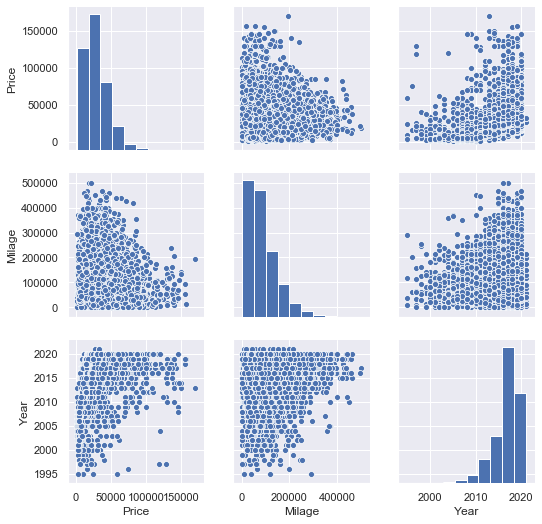

In [189]:
# pairplot for numerical features
num_features = ["Price", "Milage", "Year"]
sns.pairplot(csql_DF_cleaned[num_features], size = 2.5)
plt.show();

In [190]:
csql_DF_cleaned.describe()


,index,Price,Milage,Year
count,23678.000000,23678.000000,23678.000000,23678.000000
mean,11847.473435,29528.874525,83962.430400,2016.588563
std,6842.099215,17250.887108,63802.640491,3.074993
min,0.000000,1495.000000,10.000000,1995.000000
25%,5922.250000,16786.250000,37345.000000,2015.000000
50%,11844.500000,25985.000000,69000.000000,2017.000000
75%,17772.750000,38986.750000,116000.000000,2019.000000
max,23707.000000,169800.000000,500000.000000,2021.000000


#### Normalizing the distribution of Prices

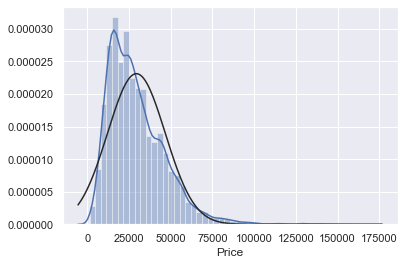

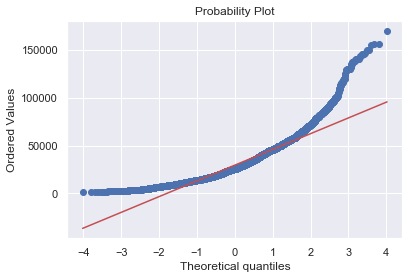

In [191]:
# Distribution of prices
from scipy.stats import norm
from scipy import stats

# Using Histogram and normal probability plot
sns.distplot(csql_DF_cleaned['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(csql_DF_cleaned['Price'], plot=plt)

In [192]:
# Finding most important features relative to Price
corr = csql_DF_cleaned.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

Price     1.000000
Year      0.516432
Milage   -0.005779
index    -0.049201
Name: Price, dtype: float64


In [193]:
#applying log transformation
csql_DF_cleaned['Price'] = np.log(csql_DF_cleaned['Price'])

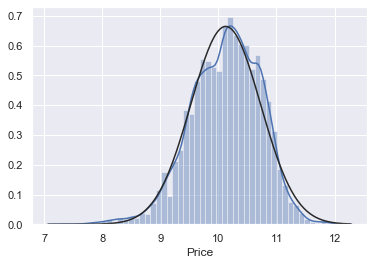

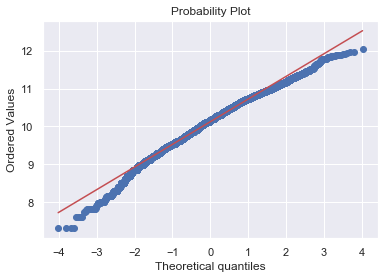

In [194]:
#transformed histogram and normal probability plot
sns.distplot(csql_DF_cleaned['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(csql_DF_cleaned['Price'], plot=plt)

In [195]:
# Finding most important features relative to Price
corr = csql_DF_cleaned.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

Price     1.000000
Year      0.644283
Milage   -0.004134
index    -0.117604
Name: Price, dtype: float64


In [196]:
csql_DF_cleaned.describe()

,index,Price,Milage,Year
count,23678.000000,23678.000000,23678.000000,23678.000000
mean,11847.473435,10.125652,83962.430400,2016.588563
std,6842.099215,0.600543,63802.640491,3.074993
min,0.000000,7.309881,10.000000,1995.000000
25%,5922.250000,9.728315,37345.000000,2015.000000
50%,11844.500000,10.165275,69000.000000,2017.000000
75%,17772.750000,10.570977,116000.000000,2019.000000
max,23707.000000,12.042377,500000.000000,2021.000000


In [197]:
csql_DF_cleaned.to_sql(name='cleanedcardb2', con=engine, if_exists='replace', index=True)

In [200]:
conn = sqlite3.connect('cleanedcar.sqlite')
csql_DF_cleaned.to_sql('cleanedcarsdb', conn, if_exists='replace', index=False)